# Assessing Biochemical Properties in Predicting IDPs
Simple notebook to see if any of the AAIndex features could be valuable for predicting IDPs. Note that there are over 500 features so we should only use the best features for learning.

First we download IDP data from DisProt:

In [1]:
import wget
import os.path as osp

# Check if disprot data is already downloaded:
if not osp.exists('disprot.tsv'):
    wget.download("https://disprot.org/api/search?release=2022_03&show_ambiguous=true&show_obsolete=false&format=tsv&namespace=all&get_consensus=false", "disprot.tsv")

Now we read AAIndex data and DisProt data (but make sure to drop regions if they refer to identical protein regions):

In [1]:
import pandas as pd
from aaindex.aaindex import aaindex

aa_index_feats = aaindex.record_codes()

disprot = pd.read_csv('disprot.tsv', sep='\t', header=0)
# Drop duplicates:
disprot = disprot.drop_duplicates(subset=['acc', 'start', 'end'])
disprot

,acc,name,organism,ncbi_taxon_id,disprot_id,region_id,start,end,term_namespace,term,ec,reference,region_sequence,confidence,obsolete
0,P03265,DNA-binding protein,Human adenovirus C serotype 5,28285,DP00003,DP00003r002,294,334,Structural state,IDPO:00076,ECO:0006220,pmid:8632448,EHVIEMDVTSENGQRALKEQSSKAKIVKNRWGRNVVQISNT,NaN,NaN
1,P03265,DNA-binding protein,Human adenovirus C serotype 5,28285,DP00003,DP00003r004,454,464,Structural state,IDPO:00076,ECO:0006220,pmid:8632448,VYRNSRAQGGG,NaN,NaN
2,P49913,Cathelicidin antimicrobial peptide,Homo sapiens,9606,DP00004,DP00004r001,134,170,Structural state,IDPO:00076,ECO:0006206,pmid:9452503,LLGDFFRKSKEKIGKEFKRIVQRIKDFLRNLVPRTES,NaN,NaN
5,P03045,Antitermination protein N,Escherichia phage lambda,10710,DP00005,DP00005r001,1,107,Structural state,IDPO:00076,ECO:0006165,pmid:9659923,MDAQTRRRERRAEKQAQWKAANPLLVGVSAKPVNRPILSLNRKPKS...,NaN,NaN
14,P03045,Antitermination protein N,Escherichia phage lambda,10710,DP00005,DP00005r012,1,22,Structural transition,IDPO:00050,ECO:0006165,pmid:9659923,MDAQTRRRERRAEKQAQWKAAN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10007,A0A2Z5UJ33,Nucleoprotein,Influenza A virus,382835,DP03573,DP03573r005,73,91,Structural state,IDPO:00076,ECO:0006220,pmid:17151603,ERRNKYLEEHPSAGKDPKK,NaN,NaN
10008,A0A2Z5UJ33,Nucleoprotein,Influenza A virus,382835,DP03573,DP03573r006,203,212,Structural state,IDPO:00076,ECO:0006220,pmid:17151603,DRNFWRGENG,NaN,NaN
10010,P03496,Non-structural protein 1,Influenza A virus (strain A/Puerto Rico/8/1934...,211044,DP03575,DP03575r001,204,230,Structural state,IDPO:00076,ECO:0006220,pmid:21464929,RSSNENGRPPLTPKQKREMAGTIRSEV,NaN,NaN
10011,P03496,Non-structural protein 1,Influenza A virus (strain A/Puerto Rico/8/1934...,211044,DP03575,DP03575r002,73,82,Structural state,IDPO:00076,ECO:0006220,pmid:20133840,SDEALKMTMA,NaN,NaN


Now we query UniProt to get the full sequence for each of the proteins in DisProt:

In [3]:
import requests
import time

def full_seq_from_uniprot(uniprot_id):
    url = 'https://www.uniprot.org/uniprot/' + uniprot_id + '.fasta'
    fasta = requests.get(url).text
    #time.sleep(1)
    return "".join(fasta.split('\n')[1:])

asc2seq = {}
for acc in disprot['acc'].unique():
    asc2seq[acc] = full_seq_from_uniprot(acc)

len(asc2seq)

2365

Next, we take the full sequence and strip out IDP regions, so we are only left with non-IDP regions:

In [4]:
def get_non_disordered_data(seq, regions):
    for region in sorted(regions, key=lambda x: x[0], reverse=True):
        seq = seq[:region[0]] + seq[region[1]:]
    return seq

asc2non_disordered_seq = {}
for acc in asc2seq:
    start_pos = disprot.loc[disprot['acc'] == acc, 'start'].values
    end_pos = disprot.loc[disprot['acc'] == acc, 'end'].values
    asc2non_disordered_seq[acc] = get_non_disordered_data(asc2seq[acc], list(zip(start_pos, end_pos)))

len(asc2non_disordered_seq)

2365

For each of the IDP and non-IDP regions, we calculate the average of the AAIndex features for us to do very simple analyses:

In [5]:
import numpy as np

def get_avg_feats_per_sequence(seq):
    features = np.zeros(len(aa_index_feats))
    for i, feat in enumerate(aa_index_feats):
        feat_vals = aaindex[feat]['values']
        features[i] = np.average(np.array([feat_vals[aa] for aa in seq.replace('X', '').replace('U', '').replace('Z', '')]))
    return features

prepared_data = []
for asc, ordered_seq in asc2non_disordered_seq.items():
    prepared_data.append([asc, 0, disprot.loc[disprot['acc'] == asc, 'ncbi_taxon_id'].values[0], len(ordered_seq)] + list(get_avg_feats_per_sequence(ordered_seq)))

for i, row in disprot.iterrows():
    prepared_data.append([row['acc'], 1, row['ncbi_taxon_id'], len(row['region_sequence'])] + list(get_avg_feats_per_sequence(row['region_sequence'])))

prepared_data = pd.DataFrame(prepared_data, columns=['asc', 'is_disordered', 'taxon', 'seq_length']+[f'{feat}_avg' for feat in aa_index_feats])

prepared_data.head()

E:\Users\austi\PycharmProjects\IDP-Predictor\venv\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
E:\Users\austi\PycharmProjects\IDP-Predictor\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,asc,is_disordered,taxon,seq_length,ANDN920101_avg,ARGP820101_avg,ARGP820102_avg,ARGP820103_avg,AURR980101_avg,AURR980102_avg,...,YUTK870104_avg,ZASB820101_avg,ZHOH040101_avg,ZHOH040102_avg,ZHOH040103_avg,ZIMJ680101_avg,ZIMJ680102_avg,ZIMJ680103_avg,ZIMJ680104_avg,ZIMJ680105_avg
0,P03265,0,28285,479,4.377641,0.904342,0.970501,1.018914,1.021482,1.014948,...,17.175470,-0.156228,2.749415,2.856054,12.326514,1.272234,14.983299,15.802401,6.103758,9.526305
1,P49913,0,9606,134,4.367090,0.887015,1.068507,1.090373,0.998955,0.990000,...,17.045000,-0.152060,2.848507,2.941045,12.744030,1.287090,15.187239,14.644030,6.095075,9.676866
2,P03045,0,10710,1,4.520000,1.180000,2.670000,2.960000,0.880000,1.120000,...,18.490000,-0.107000,3.630000,3.910000,15.700000,1.400000,16.250000,1.430000,5.740000,14.900000
3,P00004,0,9796,1,4.520000,1.180000,2.670000,2.960000,0.880000,1.120000,...,18.490000,-0.107000,3.630000,3.910000,15.700000,1.400000,16.250000,1.430000,5.740000,14.900000
4,P27695,0,9606,193,4.360000,0.944352,1.061969,1.103782,1.015596,1.009275,...,17.097824,-0.138544,2.995026,3.021554,13.261658,1.345751,15.096010,13.535596,6.144145,10.127979


Save the data file:

In [6]:
prepared_data.to_csv('basic_aa_features.csv', index=False)

Preprocess the data:

In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd

prepared_data = pd.read_csv('basic_aa_features.csv', header=0)
# Remove rows with missing values:
prepared_data = prepared_data.dropna()
# Remove rows with short sequences:
prepared_data = prepared_data[prepared_data['seq_length'] > 1]

from scipy.stats import zscore
# Shift is_disordered from 0-1 to -0.5 to 0.5:
prepared_data['is_disordered'] = prepared_data['is_disordered'] - 0.5

# Z-score the features for easier interpretation (p-values are not affected in OLS):
for col in prepared_data.columns:
    if col != 'asc' and col != 'is_disordered' and col != 'taxon':
        prepared_data[col] = zscore(prepared_data[col])

prepared_data

,asc,is_disordered,taxon,seq_length,ANDN920101_avg,ARGP820101_avg,ARGP820102_avg,ARGP820103_avg,AURR980101_avg,AURR980102_avg,...,YUTK870104_avg,ZASB820101_avg,ZHOH040101_avg,ZHOH040102_avg,ZHOH040103_avg,ZIMJ680101_avg,ZIMJ680102_avg,ZIMJ680103_avg,ZIMJ680104_avg,ZIMJ680105_avg
0,P03265,-0.5,28285,0.536091,0.278658,0.499579,0.360155,0.342056,-0.020322,-0.088246,...,-0.136091,0.256938,0.297587,0.255449,0.369188,0.440817,0.407614,0.040241,0.161141,0.290198
1,P49913,-0.5,9606,-0.113707,0.067797,0.398724,0.838054,0.711161,-0.486261,-0.750936,...,-0.255985,0.395604,0.612791,0.552614,0.667072,0.504211,0.577280,-0.159101,0.144185,0.407681
4,P27695,-0.5,9606,-0.002582,-0.073883,0.732457,0.806170,0.780424,-0.142074,-0.238943,...,-0.207443,0.845276,1.078856,0.834113,1.036383,0.754541,0.501384,-0.349849,0.240006,0.759686
6,P32774,-0.5,559292,-0.164560,-0.363376,0.366053,0.417411,0.395455,-0.719813,-1.336813,...,0.187128,0.284409,0.857446,0.776395,0.992392,0.452820,0.835924,-0.223451,-0.249148,0.311969
7,P0DMM9,-0.5,9606,0.080291,0.021401,1.096387,0.550908,0.562121,0.146255,-0.119923,...,0.207152,0.629080,1.109442,1.065316,0.939710,0.967313,1.023103,-0.209315,-0.050778,1.033841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7006,A0A2Z5UJ33,0.5,382835,-0.330306,0.809633,0.253737,-1.975164,-1.927782,1.647248,1.667700,...,-0.822589,-0.194273,-0.982968,-0.424526,-1.700006,0.357167,-0.280824,2.419626,1.376814,-1.648227
7007,A0A2Z5UJ33,0.5,382835,-0.347257,1.944532,-0.654877,-2.065758,-1.739113,1.210716,2.144437,...,-2.654438,0.617175,0.280361,0.335678,-0.570100,-2.261409,-1.432054,0.983043,0.278776,-1.439188
7008,P03496,0.5,211044,-0.315238,-0.325538,-0.597103,-0.780068,-0.737047,0.194158,1.029773,...,-1.525324,-0.391042,-0.984704,-0.512925,-1.280132,-0.553365,-0.333400,0.392162,1.083147,-0.672470
7009,P03496,0.5,211044,-0.347257,1.065222,-0.521005,1.947352,2.418945,-0.919690,-0.564995,...,0.911078,-0.603850,-0.199958,-0.031450,0.072020,-0.486194,-0.152530,-0.004571,-0.719057,0.121415


Run a simple linear regression on each feature to predict disordered, controlling for sequence length:

In [12]:
# Run models on each feature:
feature_pvals = []
bonferroni_correction = len(aa_index_feats)
for feat in aa_index_feats:
    # Note there didn't appear to be much of an effect from taxa
    selected_data = prepared_data[['is_disordered', 'seq_length', feat + '_avg']]
    model = ols(f"is_disordered ~ seq_length + {feat + '_avg'}", data=selected_data)
    results = model.fit()
    feature_pvals.append({'model_pval': results.f_pvalue*bonferroni_correction, 'rsq': results.rsquared, 'seq_length_p': results.pvalues[1]*bonferroni_correction, 'feat_p': results.pvalues[2]*bonferroni_correction, 'feat': feat, 'feat_name': aaindex[feat]['description']})

all_results = pd.DataFrame.from_dict(feature_pvals)
all_results.sort_values(by='model_pval', inplace=True)
all_results

,model_pval,rsq,seq_length_p,feat_p,feat,feat_name
282,0.000000e+00,0.263413,1.058986e-183,1.255193e-242,LIFS790102,Conformational preference for parallel beta-st...
317,0.000000e+00,0.271471,3.187831e-184,7.383079e-259,NADH010105,Hydropathy scale based on self-information val...
316,0.000000e+00,0.267692,1.567250e-180,3.171356e-251,NADH010104,Hydropathy scale based on self-information val...
315,0.000000e+00,0.260241,7.207224e-181,2.750292e-236,NADH010103,Hydropathy scale based on self-information val...
314,0.000000e+00,0.238950,1.951774e-183,2.063187e-194,NADH010102,Hydropathy scale based on self-information val...
...,...,...,...,...,...,...
158,7.971692e-206,0.131485,2.513856e-207,2.528125e+02,FUKS010109,Entire chain composition of amino acids in int...
179,9.698420e-206,0.131435,2.916024e-207,3.766322e+02,GEOR030106,Linker propensity from medium dataset (linker ...
161,9.817502e-206,0.131432,3.030252e-207,3.887186e+02,FUKS010112,Entire chain compositino of amino acids in nuc...
68,1.050370e-205,0.131415,4.493012e-207,4.914785e+02,CHAM830105,The number of atoms in the side chain labelled...


A vast majority of these features are predictive. But many of these features are non-independent. Let's keep investigating
Perform a linear regression of the full feature set (not just each individually):

In [13]:
full_model = ols(f"is_disordered ~ seq_length + {' + '.join([f + '_avg' for f in aa_index_feats])}", data=prepared_data)
results = full_model.fit()
feat2pval = dict(zip(aa_index_feats, results.pvalues[2:]))
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          is_disordered   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     154.5
Date:                Wed, 30 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:15:21   Log-Likelihood:                -3160.0
No. Observations:                6793   AIC:                             6362.
Df Residuals:                    6772   BIC:                             6505.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1835      0.005     35.408      0.000       0.173       0.194
seq_length        -0.1391      0.005    -29.284      0.000      -0.148      -0.130
ANDN920101_avg -4.063e+10   1.22e+10     -3.322      0.001   -6.46e+10   -1.67e+10
ARGP820101_avg -4.734e+09   2.19e+09     -2.166      0.030   -9.02e+09    -4.5e+08
ARGP820102_avg  1.968e+08   1.21e+09      0.163      0.871   -2.18e+09    2.57e+09
ARGP820103_avg -1.948e+09   6.49e+08     -3.004      0.003   -3.22e+09   -6.77e+08
AURR980101_avg  3.603e+09   3.45e+09      1.043      0.297   -3.17e+09    1.04e+10
AURR980102_avg -1.301e+10   1.05e+10     -1.243      0.214   -3.35e+10    7.51e+09
AURR980103_avg -6.274e+09   7.77e+09     -0.808      0.419   -2.15e+10    8.95e+09
AURR980104_avg  4.366e+09   6.17e+09      0.708      0.479   -7.72e+09    1.65e+10
AURR980105_avg -3.561e+09   8.36e+09     -0.426      0.670      -2e+10    1.28e+10
AURR980106_avg   8.45e+09   2.51e+09      3.370      0.001    3.53e+09    1.34e+10
AURR980107_avg  6.724e+09   4.32e+09      1.555      0.120   -1.75e+09    1.52e+10
AURR980108_avg -4.344e+07   2.45e+09     -0.018      0.986   -4.84e+09    4.75e+09
AURR980109_avg  5.095e+09   1.47e+09      3.464      0.001    2.21e+09    7.98e+09
AURR980110_avg  1.228e+09   1.98e+09      0.621      0.534   -2.65e+09     5.1e+09
AURR980111_avg  2.474e+09   9.05e+08      2.734      0.006       7e+08    4.25e+09
AURR980112_avg  5.964e+09    3.4e+09      1.756      0.079   -6.94e+08    1.26e+10
AURR980113_avg  -7.24e+09   2.15e+09     -3.370      0.001   -1.15e+10   -3.03e+09
AURR980114_avg  5.044e+09   5.03e+09      1.002      0.316   -4.82e+09    1.49e+10
AURR980115_avg  6.807e+09   2.03e+09      3.352      0.001    2.83e+09    1.08e+10
AURR980116_avg  1.623e+10   7.92e+09      2.049      0.041       7e+08    3.18e+10
AURR980117_avg  6.825e+08   4.19e+09      0.163      0.870   -7.52e+09    8.89e+09
AURR980118_avg  2.675e+09   4.47e+09      0.599      0.549   -6.08e+09    1.14e+10
AURR980119_avg  6.851e+09   2.75e+09      2.495      0.013    1.47e+09    1.22e+10
AURR980120_avg -2.688e+09    3.5e+09     -0.769      0.442   -9.54e+09    4.17e+09
AVBF000101_avg  -1.12e+10   6.29e+09     -1.780      0.075   -2.35e+10    1.14e+09
AVBF000102_avg -2.432e+09   2.48e+09     -0.981      0.327    -7.3e+09    2.43e+09
AVBF000103_avg  5.765e+08   1.61e+09      0.358      0.720   -2.58e+09    3.73e+09
AVBF000104_avg  4.732e+09   3.08e+09      1.534      0.125   -1.31e+09    1.08e+10
AVBF000105_avg  2.119e+09   3.56e+09      0.595      0.552   -4.87e+09     9.1e+09
AVBF000106_avg -2.452e+09   2.94e+09     -0.834      0.404   -8.21e+09    3.31e+09
AVBF000107_avg  3.211e+09   4.71e+09      0.682      0.495   -6.02e+09    1.24e+10
AVBF000108_avg   1.32e+09   6.04e+09      0.219      0.827   -1.05e+10    1.32e+10
AVBF000109_a

Seems like the best R2 we can expect to get is ~0.31 but this is using lots of correlated features. So let's try to reduce the features while retaining similar R2
Print out the results from the full model OLS to get an idea of each feature's importance:

In [14]:
for feat in sorted(feat2pval.keys(), key=lambda x: feat2pval[x]):
    print(f'{feat}: {feat2pval[feat]}')

NOZY710101: 0.0005257239349440311
DAYM780201: 0.0005259116006401891
QIAN880102: 0.0005260333863178764
CIDH920105: 0.0005263649938917811
ROBB760112: 0.0005264570079184009
NADH010104: 0.0005265076520852229
QIAN880134: 0.000526529481406763
FAUJ830101: 0.0005266399414116002
KYTJ820101: 0.0005269210422577215
CHAM830108: 0.0005272431307638232
NAKH900103: 0.0005278493329082174
DESM900101: 0.000528111294833936
SWER830101: 0.0005284046799251254
OOBM850101: 0.0005287708506259432
RADA880101: 0.0005298708186818391
SUYM030101: 0.0005300740035770184
PALJ810112: 0.000532161054390793
KOEP990102: 0.0005354341698717065
FINA910102: 0.0005354996765198802
KUMS000101: 0.0005360079122829326
QIAN880135: 0.0005363196681163523
AURR980109: 0.0005364319107754436
MEEJ810102: 0.0005368170800500088
QIAN880131: 0.0005396703685110888
PRAM820103: 0.0005412102401949171
CORJ870102: 0.0005446343749148924
BLAM930101: 0.0005451593203801761
ROSM880103: 0.0005477271857663615
NAKH900108: 0.0005498069138955117
WOLS870103: 0.000

Lets see how correlated these features are with each other.

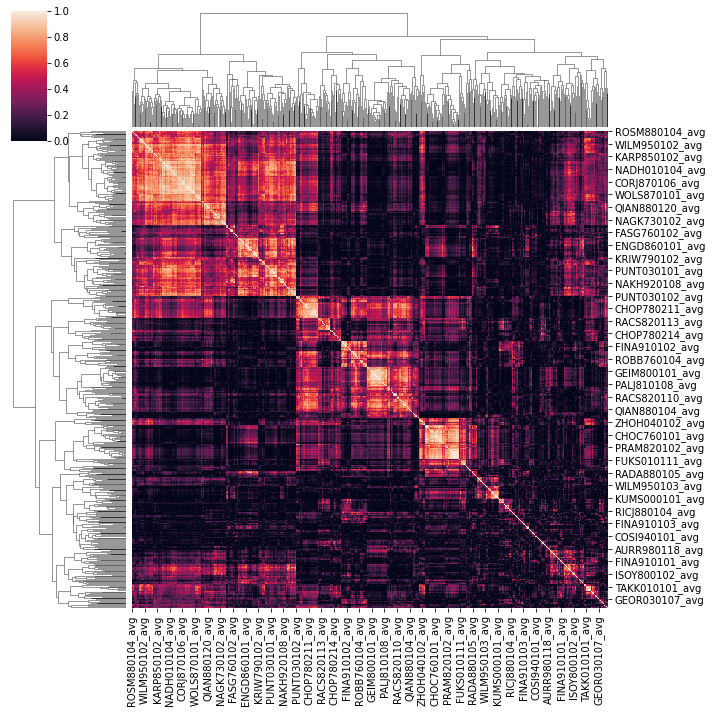

In [30]:
import seaborn as sns

# Heatmap of correlation values from features:
sns.clustermap(prepared_data[[f + "_avg" for f in aa_index_feats]].corr()**2)

There are some distinct clusters but the features seem heavily correlated with each other. Let's try to reduce the number of features to just a few. We can do this using Variation Inflation Factor (VIF) to identify how features contribute independently to the model (lower is better).

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_df = pd.DataFrame()
exog_vars = prepared_data[['seq_length'] + [f + "_avg" for f in aa_index_feats]]
exog_vars = sm.add_constant(exog_vars, prepend=False)
vif_df['VIF'] = [variance_inflation_factor(exog_vars.values, i+1) for i in range(len(aa_index_feats))]
vif_df['features'] = aa_index_feats
vif_df['feat_names'] = [aaindex[feat]['description'] for feat in aa_index_feats]
vif_df.sort_values(by='VIF', inplace=True)
vif_df

,VIF,features,feat_names
151,1.966569e+05,FUKS010102,Surface composition of amino acids in intracel...
358,2.946952e+05,OOBM850104,Optimized average non-bonded energy per atom (...
12,3.045954e+05,AURR980109,Normalized positional residue frequency at hel...
413,3.264372e+05,QIAN880113,Weights for alpha-helix at the window position...
7,3.493708e+05,AURR980104,Normalized positional residue frequency at hel...
...,...,...,...
550,1.967724e+07,WOLS870102,"Principal property value z2 (Wold et al., 1987)"
319,2.013645e+07,NADH010107,Hydropathy scale based on self-information val...
311,2.333905e+07,MUNV940104,Free energy in beta-strand region (Munoz-Serra...
175,2.665233e+07,GEOR030102,Linker propensity from 1-linker dataset (Georg...


Typically, a maximum threshold of 5 is used. But this feature set is so dense and correlated that none of these features stand out as being totally independent (yikes)! So lets build up a model from scratch until we get the optimal parameters. We'll use the previous results to determine the order at which to test the features, but lets greedily add features that don't produce high VIFs until we've seen all features.

In [5]:
curr_features = []
max_vif = 0
VIF_THRESHOLD = 10  # We will tolerate a little more multicolinearity than the standard of 5 since we have so much data
last_model_results = None
i = 0
while vif_df.shape[0] > 0:
    print("Iteration:", i)
    best_feature = vif_df.iloc[0]['features']
    curr_features.append(best_feature)
    vif_df = vif_df[vif_df['features'] != best_feature]
    minimal_vif_df = pd.DataFrame()
    minimal_exog_vars = prepared_data[['seq_length'] + [f + "_avg" for f in curr_features]]
    minimal_exog_vars = sm.add_constant(minimal_exog_vars, prepend=False)
    minimal_vif_df['VIF'] = [variance_inflation_factor(minimal_exog_vars.values, j+1) for j in range(len(curr_features))]
    minimal_vif_df['features'] = curr_features
    minimal_vif_df['feat_names'] = [aaindex[feat]['description'] for feat in curr_features]
    minimal_vif_df.sort_values(by='VIF', inplace=True)
    max_vif = minimal_vif_df['VIF'].max()
    print("Max VIF:", max_vif)
    if max_vif > VIF_THRESHOLD:
        curr_features.remove(best_feature)
    else:
        last_model_results = minimal_vif_df
    i += 1

print("Features to keep:", curr_features)
last_model_results

Iteration: 0
Max VIF: 1.0136444900407482
Iteration: 1
Max VIF: 1.1182034196399928
Iteration: 2
Max VIF: 1.3952332264896563
Iteration: 3
Max VIF: 2.1501345380466788
Iteration: 4
Max VIF: 2.76827002006797
Iteration: 5
Max VIF: 3.1613963400587695
Iteration: 6
Max VIF: 16.206878573299974
Iteration: 7
Max VIF: 3.5263759676506954
Iteration: 8
Max VIF: 7.889348102338224
Iteration: 9
Max VIF: 20.777708233074957
Iteration: 10
Max VIF: 9.463463475052798
Iteration: 11
Max VIF: 9.689234433754777
Iteration: 12
Max VIF: 14.472880467393894
Iteration: 13
Max VIF: 11.127134743297212
Iteration: 14
Max VIF: 10.089948323424906
Iteration: 15
Max VIF: 36.326069497069724
Iteration: 16
Max VIF: 16.27621130399408
Iteration: 17
Max VIF: 27.68881585077218
Iteration: 18
Max VIF: 65.08973039879179
Iteration: 19
Max VIF: 66.29495875867411
Iteration: 20
Max VIF: 10.402550145130585
Iteration: 21
Max VIF: 37.112151548815106
Iteration: 22
Max VIF: 22.34554440487052
Iteration: 23
Max VIF: 10.194401670000204
Iteration: 2

,VIF,features,feat_names
11,1.705273,JOND920102,"Relative mutability (Jones et al., 1992)"
12,1.905737,WERD780103,Free energy change of alpha(Ri) to alpha(Rh) (...
10,2.469899,NAKH920101,AA composition of CYT of single-spanning prote...
4,3.191228,AURR980104,Normalized positional residue frequency at hel...
6,3.973895,DAWD720101,"Size (Dawson, 1972)"
3,4.830155,QIAN880113,Weights for alpha-helix at the window position...
1,5.655519,OOBM850104,Optimized average non-bonded energy per atom (...
2,6.363742,AURR980109,Normalized positional residue frequency at hel...
8,7.886791,NOZY710101,"Transfer energy, organic solvent/water (Nozaki..."
0,8.689659,FUKS010102,Surface composition of amino acids in intracel...


We've reduced the selected features to 13 isntead of >500. Now lets see how a regression model with these features looks:

In [31]:
# Run the model with the selected features:
selected_data = prepared_data[['is_disordered', 'seq_length'] + [f + "_avg" for f in curr_features]]
model = ols(f"is_disordered ~ seq_length + {' + '.join([f + '_avg' for f in curr_features])}", data=selected_data)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          is_disordered   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     217.1
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:54:13   Log-Likelihood:                -3177.9
No. Observations:                6793   AIC:                             6386.
Df Residuals:                    6778   BIC:                             6488.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1839      0.005     39.201      0.000       0.175       0.193
seq_length        -0.1402      0.005    -29.507      0.000      -0.150      -0.131
FUKS010102_avg     0.0311      0.014      2.248      0.025       0.004       0.058
OOBM850104_avg     0.0175      0.011      1.570      0.116      -0.004       0.039
AURR980109_avg     0.0256      0.012      2.167      0.030       0.002       0.049
QIAN880113_avg    -0.0008      0.010     -0.073      0.942      -0.021       0.019
AURR980104_avg     0.0202      0.008      2.413      0.016       0.004       0.037
CORJ870103_avg    -0.0849      0.015     -5.738      0.000      -0.114      -0.056
DAWD720101_avg     0.0094      0.009      1.002      0.317      -0.009       0.028
OLSK800101_avg     0.0020      0.015      0.139      0.890      -0.027       0.031
NOZY710101_avg    -0.0541      0.013     -4.107      0.000      -0.080      -0.028
ROBB760112_avg     0.0581      0.014      4.131      0.000       0.031       0.086
NAKH920101_avg     0.0198      0.007      2.680      0.007       0.005       0.034
JOND920102_avg     0.0146      0.006      2.387      0.017       0.003       0.027
WERD780103_avg     0.0101      0.006      1.555      0.120      -0.003       0.023
==============================================================================
Omnibus:                     2478.978   Durbin-Watson:                   0.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           163012.446
Skew:                           0.904   Prob(JB):                         0.00
Kurtosis:                      26.930   Cond. No.                         11.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Perfect! We have a very similar R2 as the model that has the full feature set. This means we've propbaly got most of the independent data that we can get from this method. Let's take a look at the clustermap of the featrures to ensure low correlation:

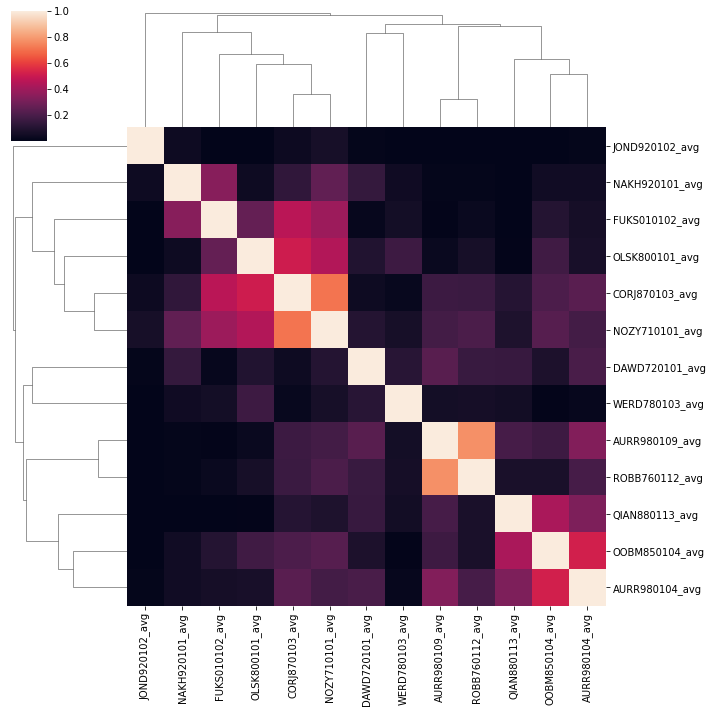

In [32]:
import seaborn as sns
sns.clustermap(selected_data[[f + "_avg" for f in curr_features]].corr()**2)

There is still some correlation with the features, but most of them are not very correlated with each other. Now, this is based off trying to do a simple IDP prediction. What if we just look at feature properties to see how correlated they are in general?

In [26]:
# All amino acid letters covered by AAINDEX:
AAs = "ALRKNMDFCPQSETGWHYIV"
aaindex_df = pd.DataFrame()
aaindex_df['AA'] = [aa for aa in AAs]
for feature in aa_index_feats:
    aaindex_df[feature] = zscore([aaindex[feature]['values'][aa] for aa in AAs])
    aaindex_df = aaindex_df.copy()  # Need to do this to avoid the pandas warning
aaindex_df

,AA,ANDN920101,ARGP820101,ARGP820102,ARGP820103,AURR980101,AURR980102,AURR980103,AURR980104,AURR980105,...,YUTK870104,ZASB820101,ZHOH040101,ZHOH040102,ZHOH040103,ZIMJ680101,ZIMJ680102,ZIMJ680103,ZIMJ680104,ZIMJ680105
0,A,-0.270241,-0.481350,0.246186,0.657435,-0.305505,-0.061016,0.271805,-0.861531,-1.034522,...,0.289360,-0.250526,-0.622360,-1.076158,-0.040513,-0.438215,-0.856513,-0.636447,-0.015368,-0.027330
1,L,-0.990882,0.661468,2.626761,2.328466,-0.251433,-1.016051,-0.177047,0.103978,-0.592734,...,0.401179,0.107880,1.078040,1.324407,1.135165,1.224150,1.335983,-0.630361,-0.026966,1.375607
2,R,-0.150134,-0.493772,-0.891845,-0.696466,0.830000,0.787904,-0.925135,-0.304507,-0.703181,...,-4.322516,0.201066,-0.266149,0.079063,-0.819003,-0.438215,-0.240842,1.798101,2.745023,-0.992988
3,K,-0.230205,0.189435,-1.054421,-1.062386,0.181140,0.363444,-0.127175,-1.195746,-0.408655,...,0.239664,0.394605,-0.662685,-0.494451,-1.200303,0.319194,0.075851,1.681055,2.153511,-1.193407
4,N,1.331185,-1.164557,-0.857007,-0.916018,-1.116579,0.310386,-0.426410,0.958082,1.211238,...,0.209845,-0.616101,-0.844151,-0.224080,-0.961990,-1.166114,-0.564180,-0.478201,-0.357517,-0.847228
5,M,0.410365,0.226700,1.976458,2.365058,-0.629935,0.681789,-0.027430,0.141113,0.106766,...,0.271967,0.072040,0.352178,0.660770,0.324900,0.122464,0.195442,-0.569497,-0.166145,0.883668
6,D,1.371221,-0.667679,-1.066033,-1.074583,1.046286,0.310386,1.967471,2.740561,2.315710,...,0.135300,-1.705656,-0.911360,-0.633733,-0.866665,-0.625108,-0.816649,1.690419,-1.888490,-1.320947
7,F,0.970864,1.270143,1.151966,1.230708,0.343355,0.681789,-0.226920,-0.378777,0.033134,...,0.137785,0.846197,1.864390,1.422724,1.627678,1.450388,0.981640,-0.620061,-0.316923,1.594246
8,C,0.930829,0.090059,1.070678,0.254924,-2.143940,-3.085293,-1.972458,-1.195746,-2.138995,...,0.110451,0.839029,0.526922,-0.723856,1.421140,0.201156,-0.422443,-0.567156,-0.566286,-1.320947
9,P,0.090080,1.183190,-0.241541,-0.318350,0.992214,1.689881,0.271805,1.292297,0.622186,...,0.341542,-0.458402,-0.682848,-0.535416,-0.596577,1.401206,0.456770,-0.562474,0.158606,0.865448


We got features for each individual AA, so lets look at a clustermap of the features to see if there are any obvious correlations:

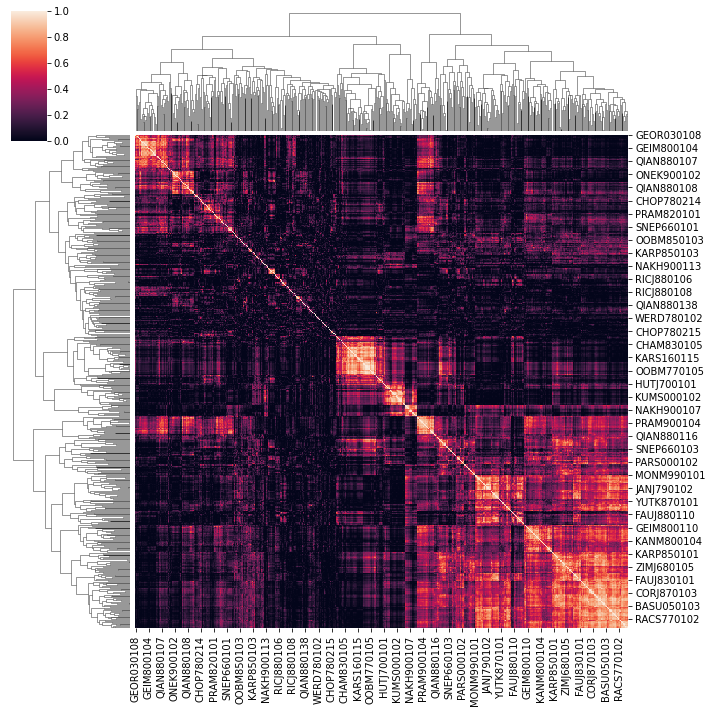

In [28]:
sns.clustermap(aaindex_df[[f for f in aa_index_feats]].corr()**2)

Once again we see lots of correlations, so lets use a similar VIF procedure again. Note that for the initial ordering we are NOT using VIF. We are using the mean correlation between the features because when using the full feature set we get infinite VIF as we can perfectly predict any of these features given all other features.

In [10]:
import scipy
import numpy as np

# Since these can all be predicted from each other. We will use average correlation as the metric to see how multicolinear they are globally
aa_corr_df = pd.DataFrame()
corrs = []
for feature in aa_index_feats:
    corrs.append(np.mean([scipy.stats.pearsonr(aaindex_df[feature], aaindex_df[f2])[0]**2 for f2 in aa_index_feats if f2 != feature], axis=0))

aa_corr_df['avg_corr'] = corrs
aa_corr_df['features'] = aa_index_feats
aa_corr_df['feat_names'] = [aaindex[feat]['description'] for feat in aa_index_feats]
aa_corr_df.sort_values(by='avg_corr', inplace=True)
aa_corr_df

,avg_corr,features,feat_names
247,0.021155,KARS160120,Weighted minimum eigenvalue based on the atomi...
520,0.023264,TANS770108,Normalized frequency of zeta R (Tanaka-Scherag...
250,0.028442,KHAG800101,"The Kerr-constant increments (Khanarian-Moore,..."
417,0.034136,QIAN880117,Weights for beta-sheet at the window position ...
539,0.034178,WERD780103,Free energy change of alpha(Ri) to alpha(Rh) (...
...,...,...,...
304,0.312946,MIYS990104,Optimized relative partition energies - method...
300,0.315640,MIYS850101,"Effective partition energy (Miyazawa-Jernigan,..."
301,0.316849,MIYS990101,Relative partition energies derived by the Bet...
302,0.317074,MIYS990102,Optimized relative partition energies - method...


Now we have a general sense of which features are correlated the least with other features. So let's run the VIF procedure again based on this ordering:

In [11]:
aa_curr_features = []
aa_max_vif = 0
aa_last_model_results = None
i = 0
with np.errstate(divide='ignore'):
    while i < len(aa_index_feats):
        print("Iteration:", i)
        best_feature = aa_corr_df.iloc[i]['features']

        aa_minimal_vif_df = pd.DataFrame()
        aa_minimal_exog_vars = aaindex_df[aa_curr_features + [best_feature]]
        aa_minimal_exog_vars = sm.add_constant(aa_minimal_exog_vars, prepend=False)
        aa_minimal_vif_df['VIF'] = [variance_inflation_factor(aa_minimal_exog_vars.values, j) for j in range(len(aa_curr_features)+1)]
        aa_minimal_vif_df['features'] = aa_curr_features+[best_feature]
        aa_minimal_vif_df['feat_names'] = [aaindex[feat]['description'] for feat in aa_curr_features+[best_feature]]
        aa_minimal_vif_df.sort_values(by='VIF', inplace=True)
        aa_max_vif = aa_minimal_vif_df['VIF'].max()
        print("Max VIF:", aa_max_vif)

        if aa_max_vif < VIF_THRESHOLD:
            aa_curr_features.append(best_feature)
            aa_last_model_results = aa_minimal_vif_df

        i += 1

print("Features to keep:", aa_curr_features)
aa_last_model_results

Iteration: 0
Max VIF: 1.0000000000000002
Iteration: 1
Max VIF: 1.04847140174613
Iteration: 2
Max VIF: 1.1113594031979783
Iteration: 3
Max VIF: 1.179322702158503
Iteration: 4
Max VIF: 1.2149725562973284
Iteration: 5
Max VIF: 1.3364224999808352
Iteration: 6
Max VIF: 5624279.48224279
Iteration: 7
Max VIF: 1.3446585407621627
Iteration: 8
Max VIF: 1.9365961267718537
Iteration: 9
Max VIF: 1.9411741358761212
Iteration: 10
Max VIF: 2.2247855809544146
Iteration: 11
Max VIF: 11.971163254258382
Iteration: 12
Max VIF: 2.2687585698955224
Iteration: 13
Max VIF: 2.9582555418215453
Iteration: 14
Max VIF: 4.287022374936867
Iteration: 15
Max VIF: inf
Iteration: 16
Max VIF: 44.74240172174234
Iteration: 17
Max VIF: 4.780186404696502
Iteration: 18
Max VIF: 5.3917775921803175
Iteration: 19
Max VIF: 8.860710089223542
Iteration: 20
Max VIF: 22.979384501914947
Iteration: 21
Max VIF: 8.942943399089446
Iteration: 22
Max VIF: 46.37440326959809
Iteration: 23
Max VIF: 16.42563171915854
Iteration: 24
Max VIF: 35.439

,VIF,features,feat_names
14,2.556091,RACS820107,Average relative fractional occurrence in A0(i...
3,3.593170,QIAN880117,Weights for beta-sheet at the window position ...
2,4.109589,KHAG800101,"The Kerr-constant increments (Khanarian-Moore,..."
10,4.238555,QIAN880139,Weights for coil at the window position of 6 (...
8,4.632617,KLEP840101,"Net charge (Klein et al., 1984)"
18,5.663928,RACS820110,Average relative fractional occurrence in EL(i...
16,5.684062,VASM830101,Relative population of conformational state A ...
6,5.986369,BUNA790103,Spin-spin coupling constants 3JHalpha-NH (Bund...
4,6.337756,WERD780103,Free energy change of alpha(Ri) to alpha(Rh) (...
5,6.964349,VELV850101,Electron-ion interaction potential (Veljkovic ...


We have 19 features that were selected using this variation of the procedure. Let's double check to see how they correlate with each other:

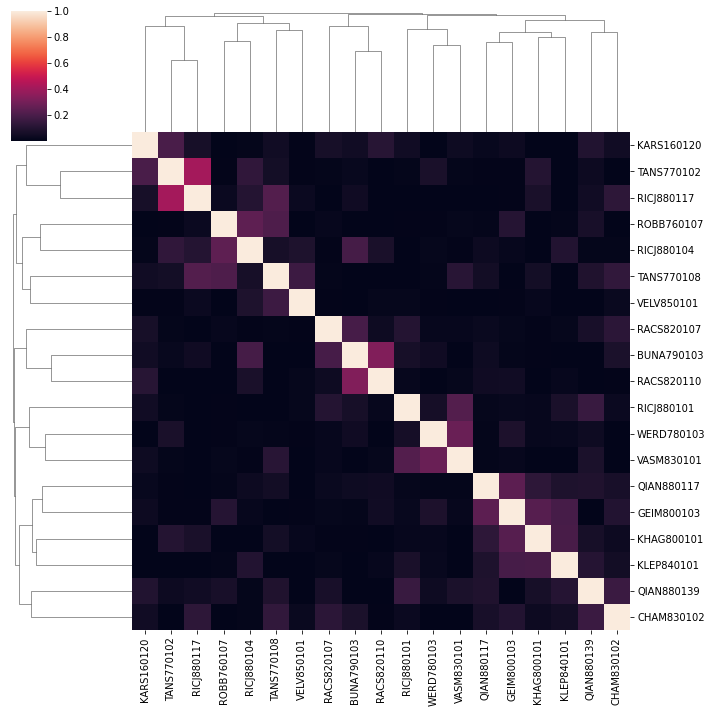

In [27]:
sns.clustermap(aaindex_df[aa_curr_features].corr()**2)

Very good! Seems that they don't correlate too well. Let's see how many features these two feature sets share:

In [33]:
shared_feats = set(aa_curr_features) & set(curr_features)
all_feats = list(set(aa_curr_features) | set(curr_features))
shared_feats

{'WERD780103'}

Okay, only one shared feature. Let's see how these features fair when doing simple IDP prediction. First let's use all the features when we combine both feature sets:

In [20]:
# Run the model with the selected features:
named_all_feats = [f + "_avg" for f in all_feats]
selected_data = prepared_data[['is_disordered', 'seq_length'] + named_all_feats]
full_model = ols(f"is_disordered ~ seq_length + {' + '.join(named_all_feats)}", data=selected_data)
full_results = full_model.fit()
full_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          is_disordered   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     153.6
Date:                Thu, 31 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:28:45   Log-Likelihood:                -3165.7
No. Observations:                6793   AIC:                             6373.
Df Residuals:                    6772   BIC:                             6517.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1839      0.005     39.254      0.000       0.175       0.193
seq_length        -0.1393      0.005    -29.327      0.000      -0.149      -0.130
QIAN880139_avg    -0.0099      0.008     -1.278      0.201      -0.025       0.005
RICJ880117_avg     0.0243      0.006      3.748      0.000       0.012       0.037
VELV850101_avg    -0.0019      0.006     -0.312      0.755      -0.014       0.010
AURR980104_avg     0.0264      0.006      4.570      0.000       0.015       0.038
AURR980109_avg    -0.0054      0.004     -1.246      0.213      -0.014       0.003
TANS770102_avg     0.0016      0.008      0.205      0.838      -0.014       0.017
CHAM830102_avg    -0.0209      0.005     -4.608      0.000      -0.030      -0.012
KARS160120_avg     0.0119      0.007      1.787      0.074      -0.001       0.025
OOBM850104_avg     0.0038      0.008      0.466      0.641      -0.012       0.020
TANS770108_avg    -0.0063      0.010     -0.657      0.511      -0.025       0.013
WERD780103_avg     0.0150      0.007      2.265      0.024       0.002       0.028
DAWD720101_avg    -0.0024      0.006     -0.437      0.662      -0.013       0.008
ROBB760112_avg     0.0149      0.004      3.927      0.000       0.007       0.022
RICJ880104_avg    -0.0046      0.005     -0.832      0.405      -0.015       0.006
GEIM800103_avg    -0.0063      0.007     -0.915      0.360      -0.020       0.007
JOND920102_avg     0.0286      0.005      5.786      0.000       0.019       0.038
ROBB760107_avg     0.0018      0.005      0.364      0.716      -0.008       0.011
RACS820107_avg     0.0016      0.005      0.344      0.731      -0.008       0.011
RACS820110_avg    -0.0082      0.007     -1.203      0.229      -0.021       0.005
NAKH920101_avg     0.0103      0.005      2.180      0.029       0.001       0.020
QIAN880117_avg     0.0160      0.006      2.905      0.004       0.005       0.027
KLEP840101_avg    -0.0198      0.009     -2.299      0.022      -0.037      -0.003
BUNA790103_avg    -0.0182      0.006     -2.892      0.004      -0.031      -0.006
OLSK800101_avg    -0.0189      0.007     -2.609      0.009      -0.033      -0.005
RICJ880101_avg    -0.0011      0.007     -0.159      0.874      -0.014       0.012
KHAG800101_avg     0.0211      0.007      2.901      0.004       0.007       0.035
VASM830101_avg    -0.0017      0.007     -0.224      0.823      -0.016       0.013
FUKS010102_avg     0.0431      0.004     10.972      0.000       0.035       0.051
QIAN880113_avg     0.0057      0.008      0.746      0.456      -0.009       0.021
NOZY710101_avg    -0.0525      0.006     -9.152      0.000      -0.064      -0.041
CORJ870103_avg    -0.0538      0.004    -13.548      0.000      -0.062      -0.046
==============================================================================
Omnibus:        

The R2 value is slightly improved compared to just using the first feature set! And very close to using every single feature. Not bad! But let's see what happens if we only use the feature shared by both sets:

In [21]:
# Compare to just the shared features:
named_shared_feats = [f + "_avg" for f in shared_feats]
selected_data = prepared_data[['is_disordered', 'seq_length'] + named_shared_feats]
shared_model = ols(f"is_disordered ~ seq_length + {' + '.join(named_shared_feats)}", data=selected_data)
shared_results = shared_model.fit()
shared_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          is_disordered   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     521.8
Date:                Thu, 31 Mar 2022   Prob (F-statistic):          1.60e-211
Time:                        15:28:56   Log-Likelihood:                -3950.8
No. Observations:                6793   AIC:                             7908.
Df Residuals:                    6790   BIC:                             7928.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1839      0.005     35.016      0.000       0.174       0.194
seq_length        -0.1679      0.005    -31.943      0.000      -0.178      -0.158
WERD780103_avg    -0.0198      0.005     -3.762      0.000      -0.030      -0.009
==============================================================================
Omnibus:                     2491.540   Durbin-Watson:                   0.247
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           285944.084
Skew:                           0.752   Prob(JB):                         0.00
Kurtosis:                      34.749   Cond. No.                         1.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R2 value is much lower. But let's do a simple ANOVA to make sure that the difference in fit is not due to random chance since we added many more features:

In [22]:
from statsmodels.stats.anova import anova_lm
# Run ANOVA to see which model is better
anova_lm(shared_results, full_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,6790.0,1272.798984,0.0,NaN,NaN,NaN
1,6772.0,1010.110659,18.0,262.688325,97.839959,1.729230e-322


We have an extremely significant difference in fit. This means that the full feature set is significantly better than just using the shared features. Let's save the feature set and some basic info about them to refer to it later!

In [25]:
# Full model is better so lets use its features
# Let's all find each of their R^2 values by themselves
all_features = pd.DataFrame()
indiv_models = [(ols(f"is_disordered ~ seq_length + {f}_avg", data=prepared_data).fit()) for f in all_feats]
all_features['features'] = all_feats
all_features['feat_names'] = [aaindex[feat]['description'] for feat in all_feats]
all_features['disorder_study'] = [f in curr_features for f in all_feats]
all_features['disorder_rsq'] = [m.rsquared for m in indiv_models]
all_features['feature_p'] = [m.pvalues[2] for m in indiv_models]
all_features['aaindex_study'] = [f in aa_curr_features for f in all_feats]
all_features.to_csv('all_selected_features.csv', index=False)
all_features

,features,feat_names,disorder_study,disorder_rsq,feature_p,aaindex_study
0,QIAN880139,Weights for coil at the window position of 6 (...,False,0.142925,1.758994e-21,True
1,RICJ880117,Relative preference value at C' (Richardson-Ri...,False,0.159805,5.279534e-51,True
2,VELV850101,Electron-ion interaction potential (Veljkovic ...,False,0.141455,6.321869e-19,True
3,AURR980104,Normalized positional residue frequency at hel...,True,0.192477,1.195276e-109,False
4,AURR980109,Normalized positional residue frequency at hel...,True,0.174396,6.346615e-77,False
5,TANS770102,Normalized frequency of isolated helix (Tanaka...,False,0.135716,6.331678e-09,True
6,CHAM830102,A parameter defined from the residuals obtaine...,False,0.140136,1.238331e-16,True
7,KARS160120,Weighted minimum eigenvalue based on the atomi...,False,0.132476,3.905687e-03,True
8,OOBM850104,Optimized average non-bonded energy per atom (...,True,0.186080,5.447562e-98,False
9,TANS770108,Normalized frequency of zeta R (Tanaka-Scherag...,False,0.131637,1.838782e-01,True
